# Problem Setup

## Imporst and loading an image of Betelgeuse

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import scipy.sparse.linalg
import scipy.optimize

(-0.5, 129.5, 129.5, -0.5)

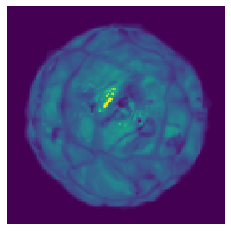

In [106]:
# Betelgeuse image from https://arxiv.org/abs/1003.1407
im_orig = matplotlib.image.imread("betelgeuse_chiavassa_et_al_2010_1640nm.png")

im_sampling = 2 #makes the code run faster but shouldn't be too low to avoid undersampling
im_sampled = np.mean(im_orig[::im_sampling,::im_sampling], axis=2)
im_sampled = im_sampled - np.min(im_sampled)
pixel_scale_mas = 0.2*im_sampling #approximate scale of the image
pixel_scale_rad = pixel_scale_mas*4.84814e-9

lam0 = 1640e-9 #wavelength in m
dlam = 1e-8 #bandwidth in m

intensity_scale = 3.5e5 #erg cm^-2 s^-1 A^-1 as given in Chiavassa et al. 2010
intensity_scale_mks = intensity_scale*1e-8*1e4*1e10

plt.imshow(im_sampled)
plt.axis("off")

## Defining its coordinates and FOV

In [74]:
N_pix = im_sampled.shape[0] #do not pad the image as in the no-LGS case
assert(im_sampled.shape[0] == im_sampled.shape[1])

Theta = pixel_scale_rad*N_pix #field of view (FOV)
M,N = np.meshgrid(np.arange(0,N_pix), np.arange(0,N_pix))

mn_to_uv_scale = lam0/Theta #how angles in the FOV map to coordinates in the uv plane

## Collector properties and flux

In [75]:
B_max = 300 #maximum baseline in m
tau_sci = 20 #exposure time in s
d_collector = 0.057 #collector diameter in m
h = 6.626e-34 
c = 3e8
theta = 1e-7 # parasitic acceleration in m/s^2*Hz^-0.5

h_orbit = 400e3 #orbit height in m
h_atmosphere = 200e3 #atmosphere height in m
R_earth = 6400e3 #Earth's radius in m
mu_earth = 3.986e14 #Earth's gravitational parameter in m^3/s^2
L_max = 2*np.sqrt((R_earth + h_orbit)**2 - (R_earth + h_atmosphere)**2) #maximum distance between LGS and interferometer such that the LOS is above the atmosphere
orbit_frac = np.arccos((R_earth + h_atmosphere)/(R_earth + h_orbit))/(2*np.pi) #fraction of during which the LOS is above the atmosphere
T = 2*np.pi*np.sqrt((R_earth + h_orbit)**3/mu_earth) #orbital period in s
n_orbits = 41 #number of orbits
tau_sci = 2 #exosure time in s
exposures_per_orbit = int(T*orbit_frac/tau_sci)

J = intensity_scale_mks/np.max(im_sampled)*im_sampled #image in units of photons/s/m^3
I = np.sum(J)*pixel_scale_rad**2*(np.pi/4)*d_collector**2*lam0*dlam/(8*h*c) #total flux in photons/s

## uv-plane coverage with one straight line per orbit (per https://doi.org/10.1117/12.2630605)

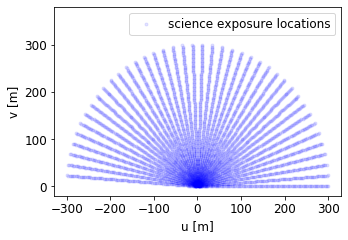

In [76]:
u = []
v = []
eps = np.finfo(np.float32).eps

for uv_orientation in np.pi/n_orbits*np.arange(n_orbits):
    u.append(B_max*np.cos(uv_orientation)*np.arange(1,eps,-1/exposures_per_orbit))
    v.append(B_max*np.sin(uv_orientation)*np.arange(1,eps,-1/exposures_per_orbit))
    
u = np.concatenate(u)
v = np.concatenate(v)

K = len(u) #total number of exposures

plt.figure(figsize=(5,3.5))
plt.rcParams.update({"font.size": 12})
plt.scatter(u,v,marker=".", color="b", alpha=0.1, label="science exposure locations")
plt.xlabel("u [m]")
plt.ylabel("v [m]")
plt.yticks([0,100,200,300])
plt.ylim(-20,380)
plt.legend()
plt.tight_layout()

## Initialise GPS errors (based on GRACE-FO data from https://podaac.jpl.nasa.gov/dataset/GRACEFO_L1B_ASCII_GRAV_JPL_RL04)

In [77]:
grace_gps_errors = np.load("grace_fo_GPS_residuals_m_2s_cadence.npy") #Difference between GRACE-FO GPS range and laser range
grace_gps_cadence = 2# cadence of the above data in s
grace_gps_times = grace_gps_cadence*np.arange(len(grace_gps_errors))

#sample random GPS erros from GRACE-FO data at given times (shorter than GRACE-FO data)
def get_gps_erros(times):
    times = np.array(times) - np.min(times)
    start = np.random.random()*(grace_gps_times[-1] - np.max(times))

    return np.interp(times + start, grace_gps_times, grace_gps_errors)

## Get random phase errors for each orbit

In [107]:
phase_errors = []

for o in range(n_orbits):
    pos_errors = get_gps_erros(tau_sci*np.arange(exposures_per_orbit))
    phase_errors.append(pos_errors*(1/L_max*B_max*2*np.pi/lam0))
    
phase_errors = np.concatenate(phase_errors)

## Define linear transform (Xi) from image (J) to complex visibility (nu_complex)

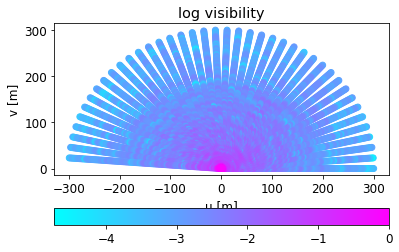

In [79]:
Xi_scaling = pixel_scale_rad**2*(np.pi/4)*d_collector**2*lam0*dlam/(8*h*c*I) #scaling such that the visibilities are <= 1

def get_Xi_rows(u, v, lam):
    modes = 2*np.pi*pixel_scale_rad/lam*np.array(list(zip(u, v)))
    
    yield Xi_scaling*np.ones(N_pix**2)
    for m_,n_ in modes:
        yield Xi_scaling*np.cos((m_*M + n_*N).ravel())
        
    for m_,n_ in modes:
        yield Xi_scaling*np.sin((m_*M + n_*N).ravel())

Xi = np.stack(list(get_Xi_rows(u, v, lam0)))
nu_complex = Xi.dot(J.ravel())

nu = np.hypot(nu_complex[1:K+1], nu_complex[K+1:])
plt.scatter(u, v, c=np.log10(nu), cmap="cool", vmax=0)
plt.title("log visibility")
plt.xlabel("u [m]")
plt.ylabel("v [m]")
plt.colorbar(orientation="horizontal")

## Add phase error due to GPS and shot noise

In [108]:
#Rotate the measured complex visibilities by phase error
def rotate_nu(nu_complex, psi):
    return np.concatenate([[1], nu_complex[1:K+1]*np.cos(psi) - nu_complex[K+1:]*np.sin(psi), nu_complex[1:K+1]*np.sin(psi) + nu_complex[K+1:]*np.cos(psi)])

perturbed_nu_complex = rotate_nu_vec(nu_complex, phase_errors)

#Add shot noise
y_a = np.random.poisson(I*tau_sci*(1 + perturbed_nu_vec[1:K+1]))
y_b = np.random.poisson(I*tau_sci*(1 - perturbed_nu_vec[1:K+1]))
y_c = np.random.poisson(I*tau_sci*(1 + perturbed_nu_vec[K+1:]))
y_d = np.random.poisson(I*tau_sci*(1 - perturbed_nu_vec[K+1:]))

#Noisy complex visibilities
measured_nu_complex = np.concatenate([[1], 2*(y_a-y_b)/(y_a+y_b+y_c+y_d), 2*(y_c-y_d)/(y_a+y_b+y_c+y_d)])

# Problem solution

## SVD of linear tranformation (Xi) from image to complex visibilities (nu)

In [81]:
n_singular_values = int(np.pi*(B_max*Theta/lam0)**2/2) #number of singular values is the same as the number of Fourier modes covered by the semi-circle in the uv plane
print(n_singular_values)
U,s,V = scipy.sparse.linalg.svds(Xi, k=n_singular_values)

3340


## Regularized pseudo inverse

In [83]:
#it is faster to multiple by the SVD matrices separately than to multiply by the whole pseudo-inverse
Xi_pinv_dot = lambda vec: V.T.dot(U.T.dot(vec)/s)
Xi_dot = lambda vec: U.dot(V.dot(vec)*s)

## Minimization of image reconstruction cost

In [109]:
#low dimensional basis for phase error: each orbits gets one parameter, i.e., a 0th order temporal approximation of phase error
phase_basis = np.kron(np.eye(n_orbits), np.ones(exposures_per_orbit))

#the cost as a function of the phase error guess
def cost(phase_coeffs):
    #derotate measure visibilites by the (low-dimensional) phase error guesses
    derotated_measured_nu_complex = rotate_nu(measured_nu_complex, phase_coeffs.dot(phase_basis))
    #project the derotated visibilities onto the object/image space spanned by the baseline and return discrepancies
    return np.linalg.norm(derotated_measured_nu_complex - U.dot(U.T.dot(derotated_measured_nu_complex)))**2

#optimization step
opt_res = scipy.optimize.minimize(cost, 2*np.pi*np.random.random(phase_basis.shape[0]), method="BFGS")

## Reconstructed image

(-0.5, 129.5, 129.5, -0.5)

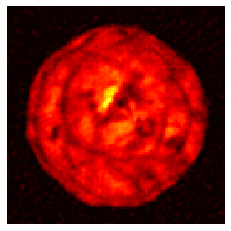

In [110]:
derotated_measured_nu_complex = rotate_nu(measured_nu_complex, opt_res.x.dot(phase_basis))
J_hat = Xi_pinv_dot(derotated_measured_nu_complex)

#The image might be "negative" due to a 180 degree phase shift that needs to be applied
if np.sum(J_hat) < 0:
    phase_shift = np.pi
    derotated_measured_complex = rotate_nu_vec(measured_nu_vec, phase_shift + opt_res.x.dot(phase_basis))
    J_hat = Xi_pinv_dot(derotated_measured_complex)
else:
    phase_shift = 0

plt.imshow(J_hat.reshape(J.shape), vmin=0, vmax=np.max(J), cmap="hot")
plt.axis("off")

## Fitted phase

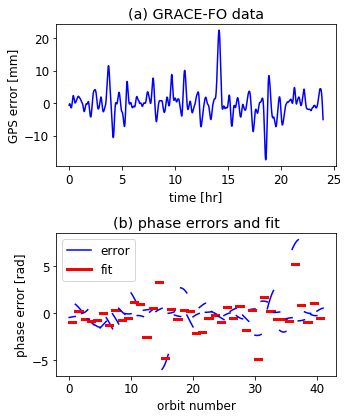

In [113]:
plt.figure(figsize=(5,6))
plt.rcParams.update({"font.size": 12})

plt.subplot(211)
plt.plot(grace_gps_times/3600, grace_gps_errors*1000, color="b")
plt.xlabel("time [hr]")
plt.title("(a) GRACE-FO data")
plt.ylabel("GPS error [mm]")
plt.subplot(212)
plt.title("(b) simulated phase errors")
orbit_numbers = np.arange(len(phase_errors))/exposures_per_orbit
for o in range(n_orbits):
    sub_pe = phase_errors[o*exposures_per_orbit:(o+1)*exposures_per_orbit]

    if o == 0:
        label_fit = "fit"
        label_error = "error"
    else:
        label_fit = None
        label_error = None
    
    fitted_pe = -opt_res.x[o] + phase_shift + round((sub_pe[0] + opt_res.x[o] - phase_shift)/(2*np.pi))*2*np.pi
    
    plt.plot(o + np.linspace(0,1,len(sub_pe)), sub_pe, color="b", label=label_error)
    plt.plot([o,o+1], [fitted_pe,fitted_pe], color="r", label=label_fit, linewidth=3)
plt.title("(b) phase errors and fit")
plt.ylabel("phase error [rad]")
plt.xlabel("orbit number")
plt.legend()
plt.tight_layout()